The goal of this tutorial is to introduce Part of Speech tagger for twitter data - http://www.ark.cs.cmu.edu/TweetNLP/

This tutorial has code from https://github.com/brendano/ark-tweet-nlp/ The code is written in Java and the python wrapper for pos tagger is from https://github.com/ianozsvald/ark-tweet-nlp-python 

Part of Speech (POS) tagging involves identifying which part of speech each token belongs to. 
This can be viewed as a task of converting input tokens w1, w2, ....., wn into tags t1, t2, ...., tn.

The 8 common parts of speech for english language are:
1. Noun
2. Verb
3. Pronoun
4. Preposition
5. Adverb
6. Conjuction
7. Participle
8. Article

Twitter data is different from standard language data in that there are tokens such as #, @, emoticons, URLs, etc, that are specific only to twitter. So the tagset for twitter needs to incorporate the tags for these new tokens.
The tags that are used to annotate tweets are as follows:

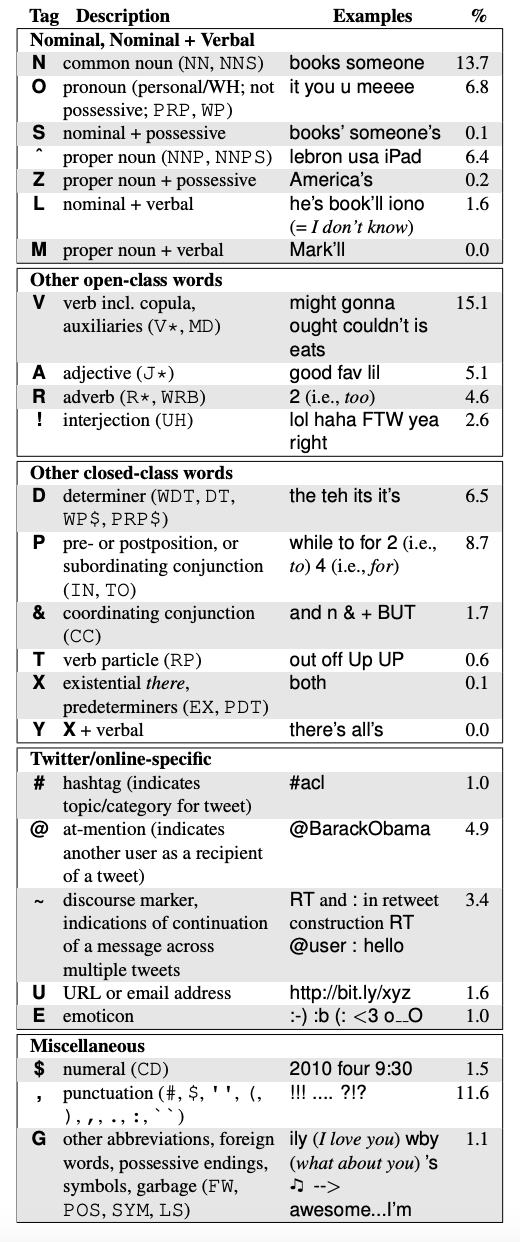

This tutorial covers how to accomplish the task of POS tagging for twitter data based on the paper - https://aclanthology.org/P11-2008.pdf

The nature of twitter data poses challenges in using standard POS taggers. The paper develops a tagset for twitter to include tags for words that are not commonly encountered in natural language outside of twitter. There are around 1800 tweets that were manually annotated with the pos tags. Conditional Random Fields (CRFs) were used with features specific to twitter POS tagging.

The features for the Conditional Random Fields incorporate the following (see paper for more details):

Twitter orthography - these features are rules that detect @, #, and URls. <br>
Names - these features check for names from a dictionary of compiled tokens which are frequently capitalized. <br>
Traditional Tag Dictionary - these are features for all tags that occur in PTB. <br>
Distributional Similarity - these features are constructed from the successor and predecessor probabilities for the 10,000 most common terms. <br>
Phonetic normalization - words are normalized to ignore alternate spellings of words using the Metaphone algorithm; e.x.{thangs, thanks, thanksss, thanx, thinks, thnx} are mapped to 0NKS. <br>
1827 tweets that are annotated are divided into training set of 1000 tweets, dev set of 327 tweets, and test set of 500 tweets. The results of the tagger incorporating the above features are compared with the standard Stanford Tagger and using the above feature set for twitter data reduces error by about 25%.

To run the tutorial you will need to download the POS tagger from https://code.google.com/archive/p/ark-tweet-nlp/downloads

This requires Java 6. https://www.oracle.com/java/technologies/java-platform.html

Place this ipython notebook that has python wrappers inside the ark-tweet-nlp-0.3.2 folder.

The first step would be to download packages required for the notebook.

In [1]:
from __future__ import unicode_literals

import operator
import re
import sys

import subprocess
import shlex

try:
    from html.parser import HTMLParser
except ImportError:
    from HTMLParser import HTMLParser
    

try:
    import html
except ImportError:
    pass  

We had earlier seen how to tokenize twitter data and saved it to a file. We will now load the contents of the file that has the tokenized data so that we can do the POS tagging.

In [9]:
file = open("Tokenized.txt", "r")

file_lines = file.read()
tokenized_tweets = file_lines.split("\n")

In [10]:
print(tokenized_tweets)

["I predict I won't win a single game I bet on . Got Cliff Lee today , so if he loses its on me RT @e_one : Texas ( cont ) http://tl.gd/6meogh@thecamion I like monkeys , but I still hate COSTCO parking lots ..@DDaimaru I may have to get minecraft after watching videos of itRT @eye_ee_duh_Esq : LMBO ! This man filed an EMERGENCY Motion for Continuance on account of the Rangers game tonight ! « Wow lmaoRT @musicdenver : Lady Gaga - Bad Romance http://dld.bz/n6XvRT @cheriexamor : When you have a good thing , hold it , squeeze it , never let it go .Texas Rangers are in the World Series ! Go Rangers !!!!!!!!! http://fb.me/D2LsXBJx"]


The functions below help clean up the tweets and call the runTagger.sh to get the POS tag predictions for the tweets that are tokenized.

In [2]:
RUN_TAGGER_CMD = "java -XX:ParallelGCThreads=2 -Xmx500m -jar ark-tweet-nlp-0.3.2.jar"

def _split_results(rows):
    """Parse the tab-delimited returned lines, modified from: https://github.com/brendano/ark-tweet-nlp/blob/master/scripts/show.py"""
    for line in rows:
        line = line.strip()  # remove '\n'
        if len(line) > 0:
            if line.count('\t') == 2:
                parts = line.split('\t')
                tokens = parts[0]
                tags = parts[1]
                confidence = float(parts[2])
                yield tokens, tags, confidence
                
                
def _call_runtagger(tweets, run_tagger_cmd=RUN_TAGGER_CMD):
    """Call runTagger.sh using a named input file"""

    # remove carriage returns as they are tweet separators for the stdin
    # interface
    tweets_cleaned = [tw.replace('\n', ' ') for tw in tweets]
    message = "\n".join(tweets_cleaned)

    # force UTF-8 encoding (from internal unicode type) to avoid .communicate encoding error as per:
    # http://stackoverflow.com/questions/3040101/python-encoding-for-pipe-communicate
    message = message.encode('utf-8')

    # build a list of args
    args = shlex.split(run_tagger_cmd)
    args.append('--output-format')
    args.append('conll')
    po = subprocess.Popen(args, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    # old call - made a direct call to runTagger.sh (not Windows friendly)
    #po = subprocess.Popen([run_tagger_cmd, '--output-format', 'conll'], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    result = po.communicate(message)
    # expect a tuple of 2 items like:
    # ('hello\t!\t0.9858\nthere\tR\t0.4168\n\n',
    # 'Listening on stdin for input.  (-h for help)\nDetected text input format\nTokenized and tagged 1 tweets (2 tokens) in 7.5 seconds: 0.1 tweets/sec, 0.3 tokens/sec\n')

    pos_result = result[0].decode('utf-8').strip('\n\n')  # get first line, remove final double carriage return
    pos_result = pos_result.split('\n\n')  # split messages by double carriage returns
    pos_results = [pr.split('\n') for pr in pos_result]  # split parts of message by each carriage return
    return pos_results


def runtagger_parse(tweets, run_tagger_cmd=RUN_TAGGER_CMD):
    """Call runTagger.sh on a list of tweets, parse the result, return lists of tuples of (term, type, confidence)"""
    pos_raw_results = _call_runtagger(tweets, run_tagger_cmd)
    pos_result = []
    for pos_raw_result in pos_raw_results:
        pos_result.append([x for x in _split_results(pos_raw_result)])
    return pos_result


def check_script_is_present(run_tagger_cmd=RUN_TAGGER_CMD):
    """Simple test to make sure we can see the script"""
    success = False
    try:
        args = shlex.split(run_tagger_cmd)
        args.append("--help")
        po = subprocess.Popen(args, stdout=subprocess.PIPE)
        # old call - made a direct call to runTagger.sh (not Windows friendly)
        #po = subprocess.Popen([run_tagger_cmd, '--help'], stdout=subprocess.PIPE)
        while not po.poll():
            lines = [l for l in po.stdout]
        # we expected the first line of --help to look like the following:
        assert "RunTagger [options]" in lines[0].decode('utf-8')
        success = True
    except OSError as err:
        print("Caught an OSError, have you specified the correct path to runTagger.sh? We are using \"%s\". Exception: %r" % (run_tagger_cmd, repr(err)))
    return success


This notebook invokes the runTagger.sh script, so we first check if the script can be located and then the pos tagger is run.

The output of the POS tagger is a tuple containing token, predicted output tag, and confidence

In [11]:
print("Checking that we can see \"%s\", this will crash if we can't" % (RUN_TAGGER_CMD))
success = check_script_is_present()
if success:
    print(runtagger_parse(tokenized_tweets))

Checking that we can see "java -XX:ParallelGCThreads=2 -Xmx500m -jar ark-tweet-nlp-0.3.2.jar", this will crash if we can't
[[('I', 'O', 0.9983), ('predict', 'V', 0.9996), ('I', 'O', 0.9981), ("won't", 'V', 0.9981), ('win', 'V', 0.9993), ('a', 'D', 0.9987), ('single', 'A', 0.9758), ('game', 'N', 0.9988), ('I', 'O', 0.9922), ('bet', 'V', 0.9995), ('on', 'P', 0.7823), ('.', ',', 0.9919), ('Got', 'V', 0.9884), ('Cliff', '^', 0.9926), ('Lee', '^', 0.9998), ('today', 'N', 0.9899), (',', ',', 0.9988), ('so', 'P', 0.6624), ('if', 'P', 0.997), ('he', 'O', 0.9979), ('loses', 'V', 0.9996), ('its', 'L', 0.9865), ('on', 'P', 0.9871), ('me', 'O', 0.9986), ('RT', '~', 0.965), ('@e_one', '@', 0.9987), (':', '~', 0.9672), ('Texas', '^', 0.9989), ('(', ',', 0.9681), ('cont', '~', 0.912), (')', ',', 0.9331), ('http://tl.gd/6meogh@thecamion', 'U', 0.9966), ('I', 'O', 0.9932), ('like', 'V', 0.87), ('monkeys', 'N', 0.9473), (',', ',', 0.999), ('but', '&', 0.9974), ('I', 'O', 0.9988), ('still', 'R', 0.9858),